### Установка

In [ ]:
!pip install rdkit
!pip install descriptastorus
!pip install plotly

In [ ]:
!pip install chemprop

In [ ]:
!pip install torch-geometric

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole
from descriptastorus.descriptors import rdNormalizedDescriptors, rdDescriptors

from math import sqrt

from xgboost import XGBRegressor

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

import plotly.graph_objs as go
import plotly.express as px

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

from multiprocessing import Pool
from tqdm import tqdm

from chemprop.features import morgan_binary_features_generator

# Подготовка к запуску

## Подготовка df_1

In [ ]:
df_1 = pd.read_excel('1400.xlsx', sheet_name='Smile-IC50-CC50')
df_1['SI'] = df_1['CC50-MDCK, mmg/ml']/df_1['IC50, mmg/ml']
df_1['S_leng'] = df_1['SMILES'].str.len ()
df_1 = df_1.drop(['Title', 'Pictures', 'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA'], axis=1)
# df_1.describe()

In [ ]:
df_1 = df_1[df_1['IC50, mmg/ml'] < 250]
df_1 = df_1[df_1['CC50-MDCK, mmg/ml'] < 500]
df_1 = df_1[df_1['SI'] <= 100]
df_1 = df_1[(df_1['S_leng'] <= 200) & (0 <= df_1['S_leng'])]
df_1 = df_1[df_1['Molecular weight'] <= 1250]

df_1 = df_1.dropna()

<Axes: xlabel='SI', ylabel='Count'>

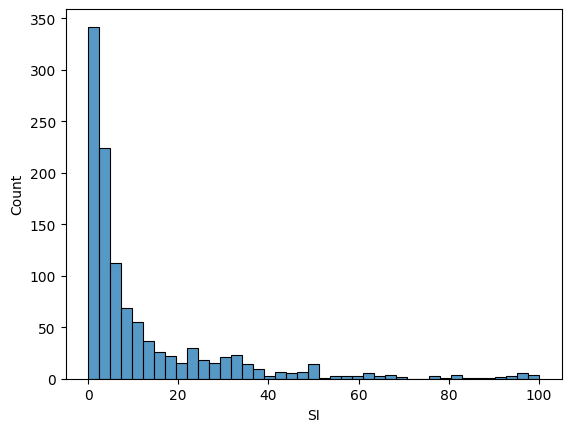

In [ ]:
sns.histplot(df_1['SI'])

<Axes: xlabel='CC50-MDCK, mmg/ml', ylabel='Count'>

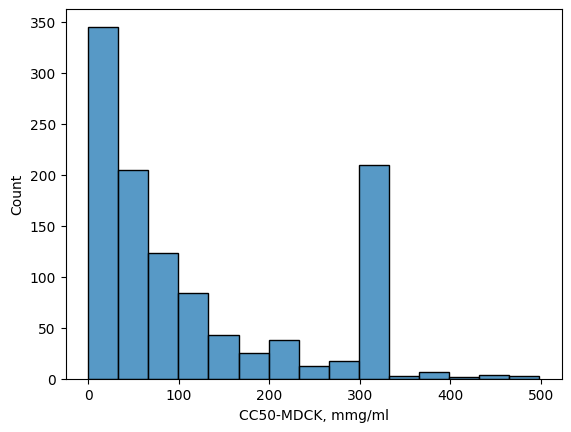

In [ ]:
sns.histplot(df_1['CC50-MDCK, mmg/ml'])

<Axes: xlabel='IC50, mmg/ml', ylabel='Count'>

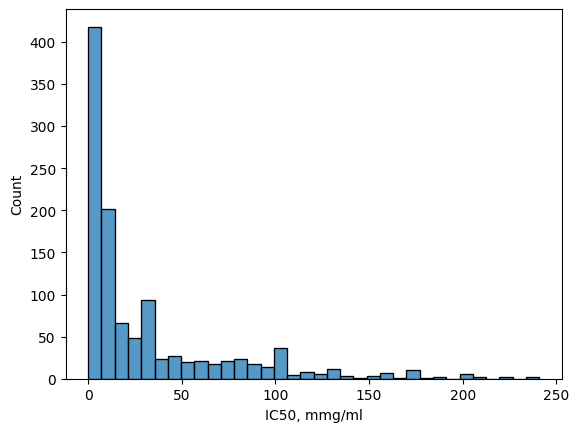

In [ ]:
sns.histplot(df_1['IC50, mmg/ml'])

<Axes: xlabel='Molecular weight', ylabel='Count'>

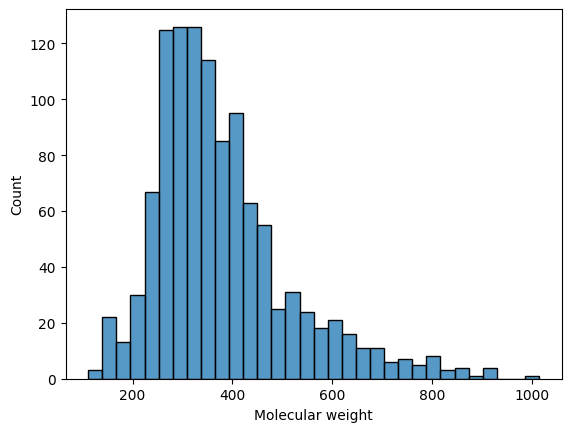

In [ ]:
sns.histplot(df_1['Molecular weight'])

<Axes: xlabel='S_leng', ylabel='Count'>

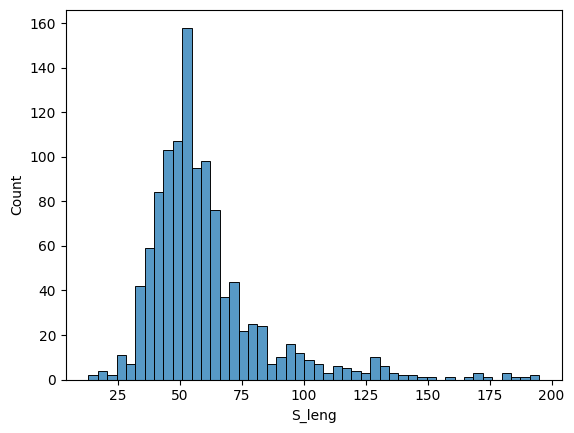

In [ ]:
sns.histplot(df_1['S_leng'])

In [ ]:
df_1 = df_1.drop(['CC50-MDCK, mmg/ml', 'IC50, mmg/ml', 'S_leng', 'Molecular weight'], axis=1)

In [ ]:
df_1.describe()

,SI
count,1120.000000
mean,12.638341
std,18.196130
min,0.036161
25%,1.991431
50%,4.770054
75%,14.709059
max,100.000000


## Дескрипторы

### Дескриптор 1 c 200 признаками с хабра

In [ ]:
def create_feature_dataframe(df):
    feature_names = [x[0] for x in generator.columns]

    rdkit_feats = []
    for i in range(len(df)):
        smiles = df.iloc[i]['SMILES']
        target_value = df.iloc[i]['SI']
        features = generator.process(smiles)
        dictionary = dict(zip(feature_names, features[1:]))
        dictionary['target'] = target_value
        rdkit_feats.append(dictionary)

    return pd.DataFrame(rdkit_feats)

In [ ]:
# generator = rdNormalizedDescriptors.RDKit2DNormalized()
# new_df_1 = create_feature_dataframe(df_1)
# new_df_1 = new_df_1.dropna()

In [ ]:
# removed_indices = new_df_1[new_df_1.isna().any(axis=1)].index
# df_1.reset_index(inplace=True, drop=True)
# df_1 = df_1.drop(removed_indices)

In [ ]:
# new_df_1.describe()

In [ ]:
# new_df.to_csv('new_df_2 IC50 до 15 около 35к.csv', index=False)

### Дескриптор 2 chem_desc

In [ ]:
def chem_desc(df):
    mols = df['SMILES'].to_list()
    mols = list(map(Chem.MolFromSmiles, mols))
    descrs = [Descriptors.CalcMolDescriptors(mol) for mol in mols]
    df_with_new_desc = pd.DataFrame(descrs)
    df_with_new_desc['target'] = list(df['SI'])
    return df_with_new_desc

In [ ]:
# new_df_2 = chem_desc(df_1)
# new_df_2 = new_df_2.dropna()

In [ ]:
# new_df_2.describe()

### Дескриптор 3 morgan_fingerprint

In [ ]:
def morgan_fingerprint(df):
    mols = df['SMILES'].to_list()
    mols = list(map(Chem.MolFromSmiles, mols))
    descrs = [morgan_binary_features_generator(mol) for mol in mols]
    df_with_new_desc = pd.DataFrame(descrs)
    df_with_new_desc['target'] = list(df['SI'])
    return df_with_new_desc

In [ ]:
# new_df_3 = morgan_fingerprint(df_1)
# new_df_3 = new_df_3.dropna()

In [ ]:
# new_df_3.describe()

## Разбиение new_df на тест и стади

In [ ]:
def data_set_cut(new_df, fraction):
    train_data, test_data = train_test_split(new_df, train_size=fraction, random_state=42)
    X_train = train_data.drop(columns=['target'])
    y_train = train_data['target']
    X_test = test_data.drop(columns=['target'])
    y_test = test_data['target']
    return X_train, y_train, X_test, y_test

## Метод главных компонент

In [ ]:
def reduce_dimensionality(df, variance_threshold):
    if variance_threshold == 1:
        return df
    # Разделите DataFrame на матрицу признаков X и столбец target y
    X = df.drop(columns=['target'])
    y = df['target']

    # Создайте объект PCA и обучите его
    pca = PCA()
    pca.fit(X)

    # Определите количество компонент, чтобы объяснить заданный уровень дисперсии
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    # # Создайте график зависимости дисперсии от количества компонент
    # plt.figure(figsize=(10, 6))
    # plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    # plt.xlabel('Number of Components')
    # plt.ylabel('Cumulative Explained Variance')
    # plt.title('Cumulative Explained Variance vs. Number of Components')
    # plt.grid()

    # Создайте новый объект PCA с выбранным количеством компонент
    pca_selected = PCA(n_components=n_components)

    # Примените PCA к данным
    X_reduced = pca_selected.fit_transform(X)

    # Создайте DataFrame с сокращенными признаками и добавьте столбец target обратно
    df_reduced = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
    df_reduced['target'] = y
    df_reduced.dropna(inplace=True)
    return df_reduced

## Модели

### XGBRegressor

In [ ]:
def XGBRegressor_model(X_train, X_test, y_train, y_test):
    # Создание и обучение модели линейной регрессии
    model = XGBRegressor()
    model.fit(X_train, y_train)

    # Предсказания на тестовом наборе
    y_pred = model.predict(X_test)

    return y_pred

### linear_regression

In [ ]:
def linear_regression_model(X_train, X_test, y_train, y_test):
    # Создание и обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Предсказания на тестовом наборе
    y_pred = model.predict(X_test)

    return y_pred

### lasso_regression

In [ ]:
def lasso_regression_model(X_train, X_test, y_train, y_test):

    model = Lasso(alpha=0.01)  # Вы можете настроить параметр alpha
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

### ridge_regression

In [ ]:
def ridge_regression_model(X_train, X_test, y_train, y_test):

    model = Ridge(alpha=0.01)  # Вы можете настроить параметр alpha
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

### random_forest_regression

In [ ]:
def random_forest_regression_model(X_train, X_test, y_train, y_test):

    model = Ridge(alpha=0.01)  # Вы можете настроить параметр alpha
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

### gradient_boosting_regression

In [ ]:
def gradient_boosting_regression_model(X_train, X_test, y_train, y_test):

    model = GradientBoostingRegressor(n_estimators=100)  # Вы можете настроить количество деревьев и другие параметры
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

### svr_regression

In [ ]:
def svr_regression_model(X_train, X_test, y_train, y_test):

    model = SVR(kernel='linear')  # Вы можете выбрать различные ядра, такие как 'linear', 'poly', 'rbf', и настроить другие параметры
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

### NNS

In [ ]:
def Neural_model(X_train, X_test, y_train, y_test):
    amount_features = X_train.shape[1]
    train_feature = tf.reshape(tf.cast(X_train, tf.float32), [-1, amount_features])
    test_feature = tf.reshape(tf.cast(X_test, tf.float32), [-1, amount_features])

    train_target = tf.reshape(tf.cast(y_train, tf.float32), [-1, 1])
    test_target = tf.reshape(tf.cast(y_test, tf.float32), [-1, 1])

    model = Sequential()
    model.add(Dense(amount_features, activation='relu', input_shape=(train_feature.shape[1],)))
    model.add(Dense(amount_features, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mape'])
    history = model.fit(train_feature, train_target, epochs=40, validation_split=0.1, verbose=2)

    result = model.predict(X_test)

    return np.array([result[index][0] for index in range(len(result))])

## Результаты

In [ ]:
def predict(y_test, y_pred):
    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    k = 0
    for i in range(len(y_test)):
        if (((y_test[i] >= 8) and (y_pred[i] >= 8)) or ((y_test[i] < 8) and (y_pred[i] < 8))):
            k += 1
    return k*100/len(y_test)

In [ ]:
def results(y_test, y_pred):
    # Вычисление метрик оценки качества модели
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)**0.5

    y_test = y_test.tolist()
    y_pred = y_pred.tolist()
    k = 0
    for i in range(len(y_test)):
        if (((y_test[i] >= 8) and (y_pred[i] >=8)) or ((y_test[i] < 8) and (y_pred[i] < 8))):
            k += 1
    predict_volume = k*100/len(y_test)
    # # Возвращение предсказанных значений и метрик
    # print("Mean Absolute Percentage Error (MAPE):", mape)
    # print("Root Mean Squared Error (RMSE):", rmse)
    # print("Mean Squared Error (MSE):", mse)
    # print("Mean Absolute Error (MAE):", mae)
    # print('='*40)

    return mape, rmse, mse, mae, predict_volume

In [ ]:
def graf(y_test, y_pred):
    # Строим график
    point_numbers = [int(index) for index in range(len(y_test))]

    # Используем zip для объединения массивов и сортируем их по значениям arr1
    sorted_arrays = sorted(zip(y_test, y_pred))
    # Разделяем отсортированные значения обратно на два массива
    y_test, y_pred = zip(*sorted_arrays)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=point_numbers, y=y_pred, name='Предсказанные значения', marker=dict(size=8)))
    fig.add_trace(go.Scatter(x=point_numbers, y=y_test, name='Реальные значения', marker=dict(size=8)))

    # Настройка размера
    fig.update_traces(marker=dict(size=8))

    # Добавление легенды
    fig.update_layout(legend=dict(x=0, y=1, traceorder='normal', orientation='h'))

    fig.show()

# Запуск

In [ ]:
generator = rdNormalizedDescriptors.RDKit2DNormalized()
new_df_1 = create_feature_dataframe(df_1)
new_df_1 = new_df_1.dropna()

new_df_3 = morgan_fingerprint(df_1)
new_df_3 = new_df_3.dropna()

In [ ]:
def apply_model(model, X_train, X_test, y_train, y_test):
    y_pred = model(X_train, X_test, y_train, y_test)
    mape, rmse, mse, mae, predict_volume = results(y_test, y_pred)
    # graf(y_test, y_pred)
    return mape, rmse, mse, mae, predict_volume, model.__name__

def apply_models(X_train, y_train, X_test, y_test, skip_svr=False):
    models = [
        XGBRegressor_model,
        linear_regression_model,
        lasso_regression_model,
        ridge_regression_model,
        random_forest_regression_model,
        gradient_boosting_regression_model,
        svr_regression_model,
        Neural_model
    ]
    results_list = []
    for model in models:
        if skip_svr and model == svr_regression_model:
            continue
        # print(f'Работа с моделью {model}')
        results = apply_model(model, X_train, X_test, y_train, y_test)
        results_list.append(results)
    return results_list

In [ ]:
dataframes = {
    "Дескриптор 1": new_df_1,
    # "Дескриптор 2": new_df_2,
    "Дескриптор 3": new_df_3
}

best_metrics = {
    metric: [float('inf'), '', '', '', ''] if metric != 'predict_volume' else [float('-inf'), '', '', '', '']
    for metric in ["mape", "rmse", "mse", "mae", "predict_volume"]
}

pca_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
fraction_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for df_name, new_df in dataframes.items():
    for pca_level in pca_levels:
        pca_df = reduce_dimensionality(new_df, pca_level)
        for fraction in fraction_levels:
            X_train, y_train, X_test, y_test = data_set_cut(pca_df, fraction)
            skip_svr = df_name == "Дескриптор 2"
            results_list = apply_models(X_train, y_train, X_test, y_test, skip_svr)
            for mape, rmse, mse, mae, predict_volume, model_name in results_list:
                for metric, value in zip(["mape", "rmse", "mse", "mae", "predict_volume"], [mape, rmse, mse, mae, predict_volume]):
                    if metric == 'predict_volume':
                        if value > best_metrics[metric][0]:
                            best_metrics[metric] = [value, model_name, df_name, pca_level, fraction]
                    else:
                        if value < best_metrics[metric][0]:
                            best_metrics[metric] = [value, model_name, df_name, pca_level, fraction]

print("Лучшие результаты:")
for metric in ["mape", "rmse", "mse", "mae", "predict_volume"]:
    print(f"{metric.upper()}: {best_metrics[metric][0]} в модели {best_metrics[metric][1]} с дескриптором {best_metrics[metric][2]} с уровнем дисперсии {best_metrics[metric][3]} c тренировочной выборкой {best_metrics[metric][4]}")

In [ ]:
pca_df = reduce_dimensionality(new_df_2, 0.85)
X_train, y_train, X_test, y_test = data_set_cut(pca_df, 0.9)
y_pred = Neural_model(X_train, X_test, y_train, y_test)
mape, rmse, mse, mae, predict_volume = results(y_test, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Количество угаданных", predict_volume)
print('='*40)
graf(y_test, y_pred)